# INCLUDE
Instruction to colab user:
- Run the first cell to install auto-sklearn on colab, and auto restart runtime, then proceed to run the following cells
- Run the second cell to mount google drive for I/O of dataset, results. In this notebook, dataset can be load from pickle and results can be dump to pickle.

Instruction to non-colab user:
- Ignore first two cell
- Change the paths


## Run for colab

In [ ]:
# For Colab, you need to install auto-sklearn every time
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install auto-sklearn # Downgrade scipy to 1.4.x
    #!pip install scipy # Upgrade scipy to 1.7.x

import os, signal
os.kill(os.getpid(), signal.SIGKILL) # Restart_runtime

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Run for everyone

In [2]:
# Dependencies
# Common
import os
import pickle
import sys
import time
from tqdm.autonotebook import tqdm
from datetime import datetime

import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# ML
import sklearn # Import sklearn before autosklearn, solve scipy version error
from sklearn.model_selection import train_test_split
import sklearn.datasets
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# AML
import autosklearn
import autosklearn.classification
from autosklearn.metrics import balanced_accuracy, precision, recall

# Wilcoxon test
from scipy.stats import wilcoxon

# Check machine
#import multiprocessing
#multiprocessing.cpu_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Set paths

In [3]:
# Set up paths

# User insert folder to store pickles
# dataset name in format openml_xxx.pkl
datasets_folder = '/content/drive/My Drive/Colab Notebooks/course_AML_proj/data'
results_folder = '/content/drive/My Drive/Colab Notebooks/course_AML_proj/results'

In [4]:
# Look up results directory
os.listdir(results_folder)

['experiment_20211213-092414',
 'openml_meta_features.pkl',
 'experiment_20211213-123348']

# Functions

In [5]:
def Load_result_pkl(folder_path, result_name):
    fname = os.path.join(folder_path, result_name)
    # Note if you encounter an error when testing your results,
    # Uncomment the foollowing lines to resolve the issue

    # import autosklearn.automl_common.common.utils.backend as Backend
    # sys.modules['autosklearn.util.backend'] = Backend
    file_read = open(fname, "rb")
    res = pickle.load(file_read) # Load pickle to data
    file_read.close()
    return res

def Extract(lst, item):
    return list(list(zip(*lst))[item-1])

def Prep_res_df(res, meta_features_df):
    print(pd.DataFrame({k:{'acc': v['acc'][Extract(v['acc'],1).index(np.amax(Extract(v['acc'],1)))][1], 'test_acc_mean': np.mean(Extract(v['acc'],2)), 'improvement': (v['acc'][Extract(v['acc'],1).index(np.amax(Extract(v['acc'],1)))][1]-np.mean(Extract(v['acc'],2)))/np.mean(Extract(v['acc'],2))*100} for k,v in res.items()}).T)
    res_df = pd.DataFrame({k:{'acc': v['acc'][Extract(v['acc'],1).index(np.amax(Extract(v['acc'],1)))][1], 'test_acc_mean': np.mean(Extract(v['acc'],2)), 'improvement': (v['acc'][Extract(v['acc'],1).index(np.amax(Extract(v['acc'],1)))][1]-np.mean(Extract(v['acc'],2)))/np.mean(Extract(v['acc'],2))*100} for k,v in res.items()}).T
    res_df.reset_index(inplace=True)
    res_df.rename(columns={'index': 'dataset'}, inplace=True)
    res_df = res_df.merge(
        meta_features_df, 
        how='inner', on='dataset')
    return res_df

In [41]:
def Compare_acc_meta_feature(res_df, y1, y2):
    # Plot test acc avg on each dataset
    fig, ax1 = plt.subplots(figsize=(20,4))
    ax2 = ax1.twinx()

    sns.scatterplot(x='dataset', y=y1, 
                    data=res_df.sort_values('dataset'),
                    color='r',
                    ax=ax1)
    sns.scatterplot(x='dataset', y=y2, 
                    data=res_df.sort_values('dataset'), 
                    color='b',
                    ax=ax2)

    ax2.set(yscale='log')

    ax1.tick_params(axis='x', rotation=90)
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Balanced accuracy')
    ax2.set_ylabel(y2)

    ax1.grid(color='k', linestyle='--', alpha=0.2, linewidth=1)

    fig.legend([y1, y2],
            loc='lower right')

    fig.tight_layout()

    return fig

def Scatter_acc_meta_feature(res_df):
    x, y, z = res_df['n_instance'], res_df['n_feature'], res_df['mean_acc']

    fig, ax = plt.subplots()

    plt.scatter(x=x, y=y, c=z,
                cmap='inferno')

    ax.set(xscale='log', yscale='log')

    ax.set_xlabel('n_instance')
    ax.set_ylabel('n_feature')
    ax.set_facecolor('silver')

    plt.colorbar(ax=ax)

    plt.tight_layout()

    return fig

# Load meta features

In [9]:
folder_path = results_folder

fname = os.path.join(folder_path, 'openml_meta_features.pkl')
file_read = open(fname, "rb")
meta_features = pickle.load(file_read) # Load pickle to data
file_read.close()

In [8]:
meta_features_df = pd.DataFrame(meta_features).T
meta_features_df.reset_index(inplace=True)
meta_features_df.rename(columns={'index': 'dataset'}, inplace=True)
meta_features_df.head()

,dataset,n_instance,n_feature,n_class
0,41165,10000,7200,10
1,41161,20000,4296,2
2,41159,20000,4296,2
3,41163,10000,2000,5
4,41142,5418,1636,2


# Experiment 1 part 1

In [16]:
final_df = list()

In [23]:
# final_df.append(results_df)
list_of_all_data_frames = []


In [36]:
files = os.listdir(results_folder)
print(files)
temp = []
for file in files:
  if("experiment" not in file):
    continue
  temp.append(file)
files = temp
print(files)

def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

for load_result in files:
  # load_result = 'experiment_20211212-002423'
  print(f"Loading: {load_result}")
  res1 = Load_result_pkl(results_folder, load_result)
  list_of_all_data_frames.append(Prep_res_df(res1, meta_features_df))
  # res1_df = Prep_res_df(res1, meta_features_df)
  # print(res1_df)
  del res1
  # results_df = Merge(results_df, res1_df)


['openml_meta_features.pkl', 'experiment_20211211-222843', 'experiment_20211212-110242']
['experiment_20211211-222843', 'experiment_20211212-110242']
Loading: experiment_20211211-222843
Loading: experiment_20211212-110242


EOFError: ignored

In [38]:
results_df = pd.concat(list_of_all_data_frames, ignore_index=True)
# print(list_of_all_data_frames)

In [39]:
print(results_df)

   dataset  mean_acc        sd_acc  n_instance  n_feature  n_class
0     1468  0.686179  3.855024e-01        1080        856        9
1    41164  0.142857  5.551115e-17        8237        800        7
2    40996  0.100000  2.775558e-17       70000        784       10
3     1111  0.500000  0.000000e+00       50000        230        2
4       12  0.977787  8.792063e-02        2000        216       10
5    41166  0.264318  3.354135e-02       58310        180       10
6    41138  0.500000  0.000000e+00       76000        170        2
7    41165  0.100000  2.775558e-17       10000       7200       10
8    41161  0.500000  0.000000e+00       20000       4296        2
9    41159  0.500000  0.000000e+00       20000       4296        2
10   41163  0.200000  5.551115e-17       10000       2000        5
11   41142  0.500000  0.000000e+00        5418       1636        2
12   41143  0.773175  1.700670e-02        2984        144        2
13    1486  0.500000  0.000000e+00       34465        118     

## Inspect results

In [ ]:
res_df = results_df

In [ ]:
# Worst 5
res_df.sort_values('mean_acc').head()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
14,41167,0.002817,0.0,416188,60,355
21,41169,0.080339,0.0,65196,27,100
0,41165,0.100000,0.0,10000,7200,10
7,40996,0.100000,0.0,70000,784,10
32,40685,0.142857,0.0,58000,9,7


In [ ]:
# Best 5
res_df.sort_values('mean_acc').tail()

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
5,1468,0.951517,0.010539,1080,856,9
9,12,0.979841,0.006431,2000,216,10
26,40984,0.981813,0.002698,2310,18,7
19,3,0.985300,0.001506,3196,36,2
34,40975,0.985431,0.006899,1728,6,4


In [ ]:
# Test on subset first
np.array(res_df.sort_values('mean_acc').tail(10)['dataset'])

array(['41143', '54', '1489', '40981', '41146', '1468', '12', '40984',
       '3', '40975'], dtype=object)

In [ ]:
res1['3']['cls'][1].leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,0.58,random_forest,0.012135,3.992263
9,2,0.06,lda,0.075517,2.200134
3,3,0.36,adaboost,0.109730,3.742078


## Figures

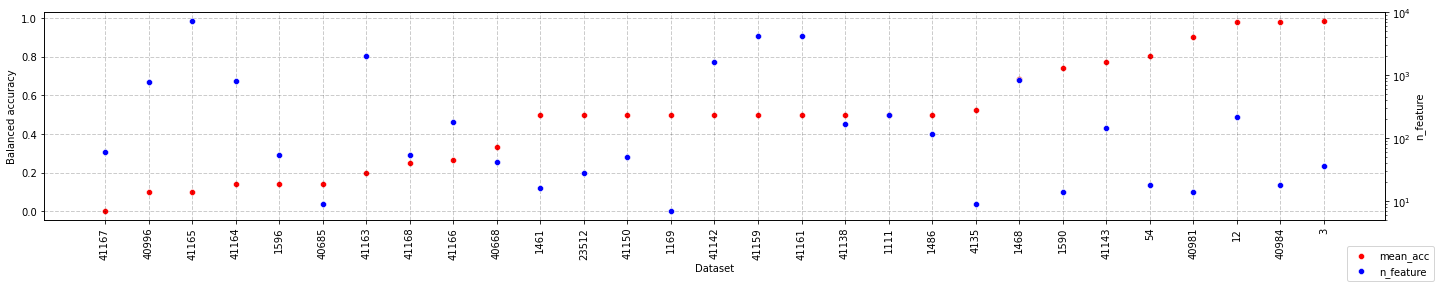

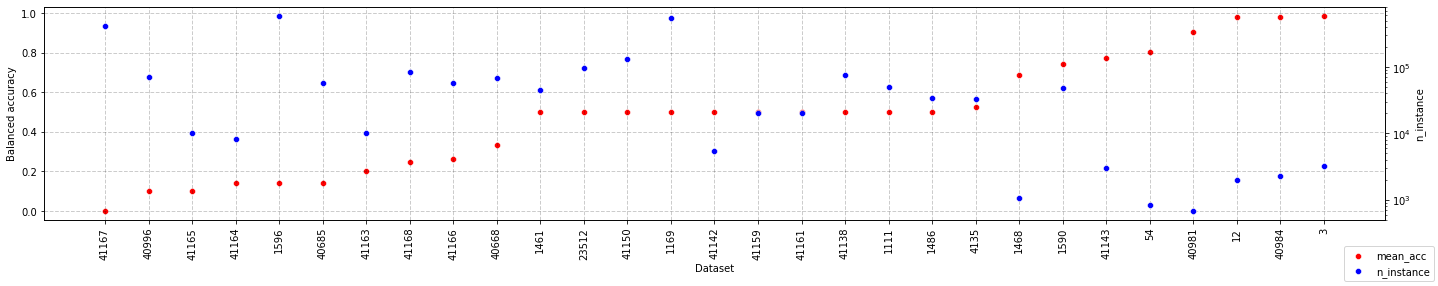

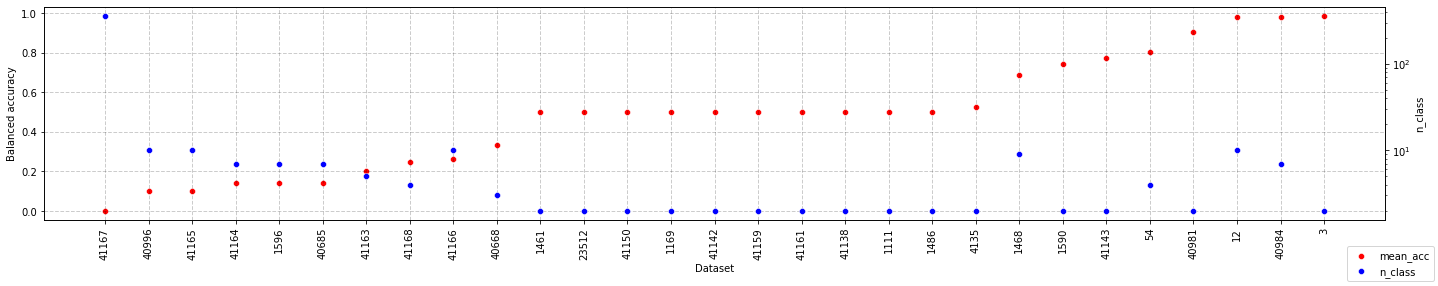

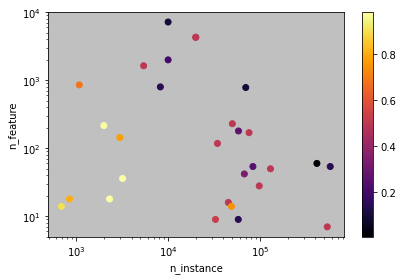

In [40]:
res_df = results_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

In [ ]:
# Not used

# Plot test acc distribution on each dataset
fig, ax = plt.subplots(figsize=(20,8))
sns.violinplot(x='dataset', y='mean_acc', 
               data=res_df.sort_values('mean_acc'), 
               ax=ax)

ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Dataset')
ax.set_ylabel('Balanced accuracy')

ax.grid(color='k', linestyle='--', alpha=0.2, linewidth=1)

fig.tight_layout()

fig_name = 'res_plot_' + fname + '.png'
#fig.savefig(fig_name)

# Experiment 1 part 2
increased time budget = 240s

## Process results

In [ ]:
load_result = 'experiment_20211203-081432.pkl'
res2 = Load_result_pkl(results_folder, load_result)
res2_df = Prep_res_df(res2, meta_features_df)

## Figures

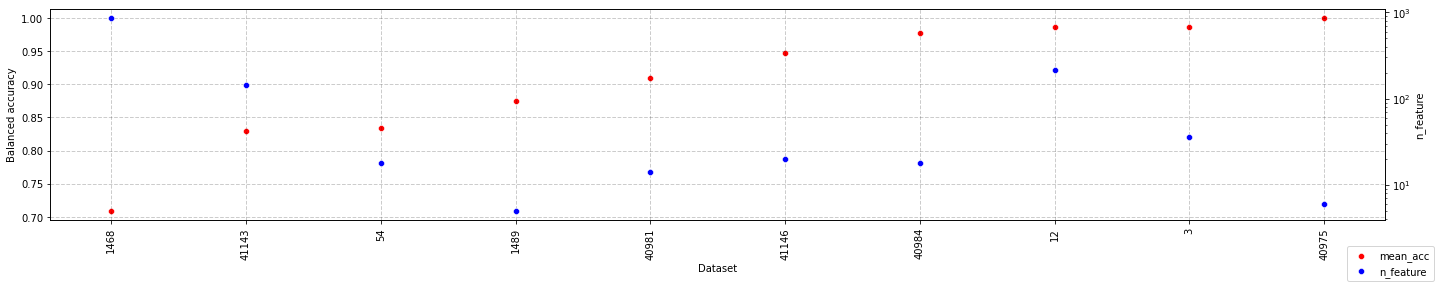

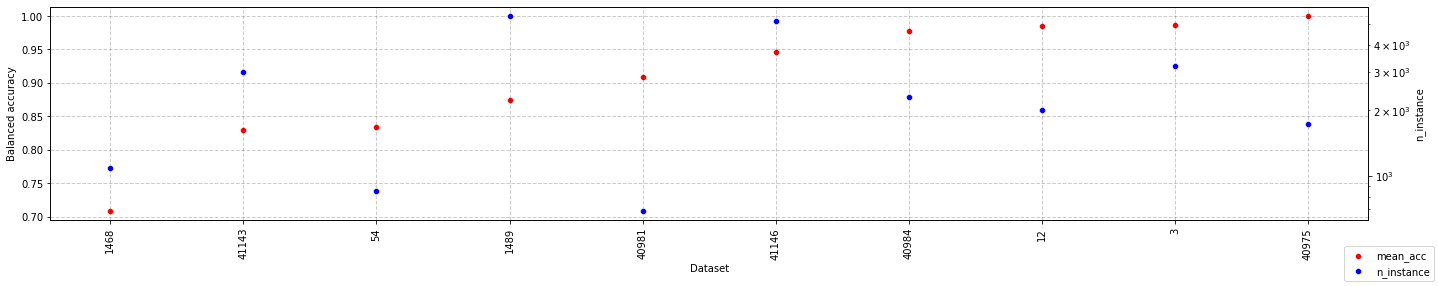

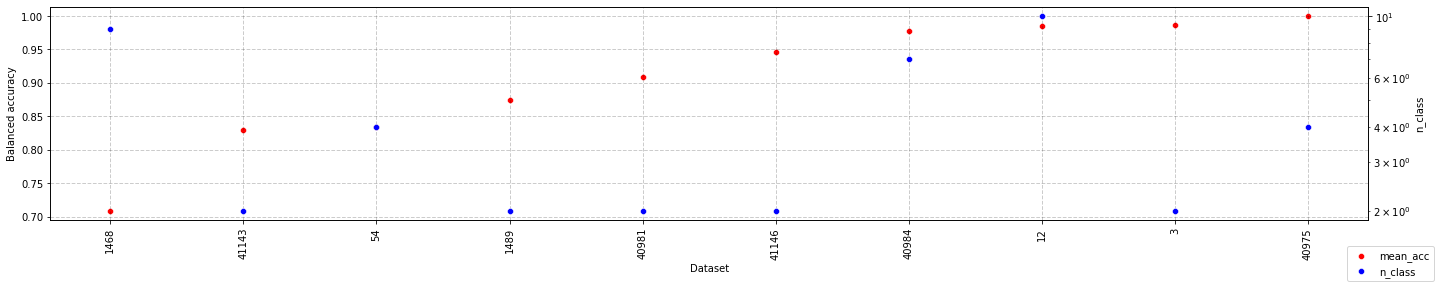

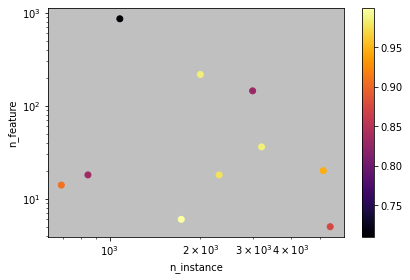

In [ ]:
res_df = res2_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

# Wilcoxon signed-rank test
To test the null hypothesis that there is no difference between two set of values, we can apply the two-sided test.

In [ ]:
# Filter out results on same dataset in two differnt run
datasets_to_compare = np.intersect1d(res1_df['dataset'], res2_df['dataset'])
# Construct result table
compare_res_df = res1_df[['dataset', 'mean_acc', 'sd_acc']].merge(
    res2_df[['dataset', 'mean_acc', 'sd_acc']], 
    on='dataset', how='inner',
    suffixes=('_exp1', '_exp2'))
# Compute difference
compare_res_df['improvement'] = compare_res_df['mean_acc_exp2'] - compare_res_df['mean_acc_exp1']
# Compute p-values for Wilcoxon signed-rank test
pvals = {dataset: wilcoxon(res1[dataset]['acc'], 
                   res2[dataset]['acc'], 
                   alternative='two-sided')[1] for dataset in datasets_to_compare}
# Merge to result table
compare_res_df['pval_signedrank'] = compare_res_df['dataset'].map(pvals).fillna('')


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [ ]:
# Show result
compare_res_df

,dataset,mean_acc_exp1,sd_acc_exp1,mean_acc_exp2,sd_acc_exp2,improvement,pval_signedrank
0,1468,0.951517,0.010539,0.709182,0.301034,-0.242335,0.062500
1,12,0.979841,0.006431,0.985477,0.003484,0.005637,0.312500
2,41143,0.798071,0.002982,0.829970,0.002243,0.031899,0.062500
3,3,0.985300,0.001506,0.986602,0.001189,0.001302,0.108809
4,41146,0.943067,0.003071,0.946819,0.002472,0.003751,0.125000
5,40984,0.981813,0.002698,0.977665,0.001179,-0.004147,0.067889
6,54,0.813181,0.019257,0.834590,0.021481,0.021409,0.125000
7,40981,0.899937,0.005826,0.908641,0.005958,0.008704,0.062500
8,40975,0.985431,0.006899,0.999438,0.001124,0.014007,0.062500
9,1489,0.868555,0.018134,0.874925,0.003547,0.006370,0.812500


# Experiment 1 part 4
- increased time budget = 600s
- memory limit = None

## Process results

In [ ]:
load_result = 'experiment_20211215-021346.pkl'
res = Load_result_pkl(results_folder, load_result)
res_df = Prep_res_df(res, meta_features_df)

In [ ]:
# Sort by performance ascending 
res_df.sort_values('mean_acc')

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
6,41169,0.080339,0.0,65196,27,100
31,40996,0.100000,0.0,70000,784,10
24,41165,0.100000,0.0,10000,7200,10
1,1596,0.142857,0.0,581012,54,7
23,41167,0.325630,0.0,416188,60,355
26,41159,0.500000,0.0,20000,4296,2
25,41161,0.500000,0.0,20000,4296,2
8,23517,0.516344,0.0,96320,21,2
18,1169,0.517897,0.0,539383,7,2
0,41168,0.565081,0.0,83733,54,4


In [ ]:
res_df.shape

(32, 6)

In [ ]:
print(res['41169']['cls'][0])
print(res['41169']['cls'][0].sprint_statistics())

AutoSklearnClassifier(memory_limit=None, metric=balanced_accuracy,
                      per_run_time_limit=60,
                      scoring_functions=[precision, recall], seed=3003105692,
                      time_left_for_this_task=600)
auto-sklearn results:
  Dataset name: 41169
  Metric: balanced_accuracy
  Best validation score: 0.081789
  Number of target algorithm runs: 11
  Number of successful target algorithm runs: 1
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 9
  Number of target algorithms that exceeded the memory limit: 0



In [ ]:
res['41169']['cls'][0].leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
3,1,1.0,lda,0.918211,2.478441,2,0.920578,0,1.639538e+09,1.639538e+09,0.0,StatusType.SUCCESS,[],[feature_agglomeration],weighting,Initial design


In [ ]:
res['3']['cls'][0]

AutoSklearnClassifier(memory_limit=None, metric=balanced_accuracy,
                      per_run_time_limit=60,
                      scoring_functions=[precision, recall], seed=3003105692,
                      time_left_for_this_task=600)

In [ ]:
print(res['3']['cls'][0].sprint_statistics())

auto-sklearn results:
  Dataset name: 3
  Metric: balanced_accuracy
  Best validation score: 0.997537
  Number of target algorithm runs: 36
  Number of successful target algorithm runs: 30
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 0



In [ ]:
res['3']['cls'][0].leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
30,1,0.04,gradient_boosting,0.002463,13.099522,29,0.000000,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[polynomial],none,Local Search
16,2,0.06,gradient_boosting,0.003605,3.094070,15,0.001170,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
12,3,0.02,gradient_boosting,0.003695,9.692729,11,0.000000,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[polynomial],none,Initial design
33,4,0.04,gradient_boosting,0.003695,5.430563,32,0.000607,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[polynomial],none,Local Search
18,5,0.08,gradient_boosting,0.006849,2.477359,17,0.006281,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
25,6,0.02,libsvm_svc,0.009582,1.371901,24,0.000000,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[feature_agglomeration],none,Initial design
23,7,0.08,extra_trees,0.013969,5.068969,22,0.000000,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[fast_ica],none,Initial design
21,8,0.02,gradient_boosting,0.014238,3.632012,20,0.004592,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[feature_agglomeration],weighting,Initial design
19,9,0.04,decision_tree,0.023281,1.450419,18,0.015334,0,1.639537e+09,1.639537e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],weighting,Initial design


## Figures

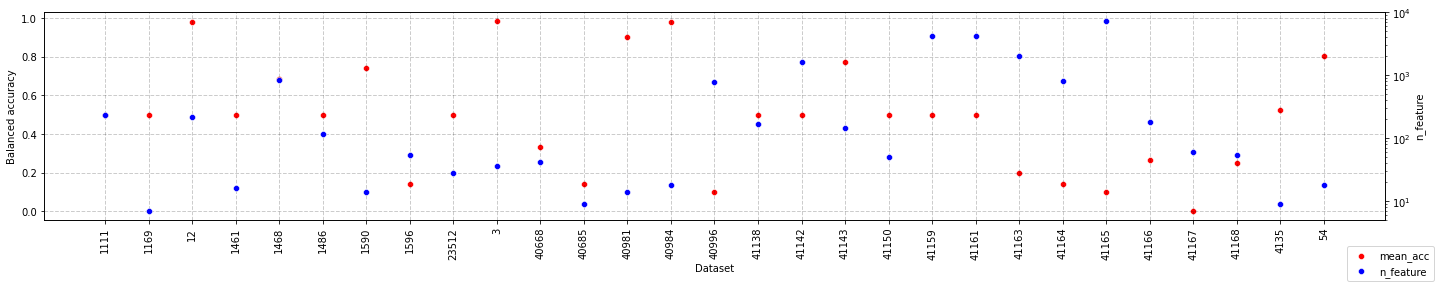

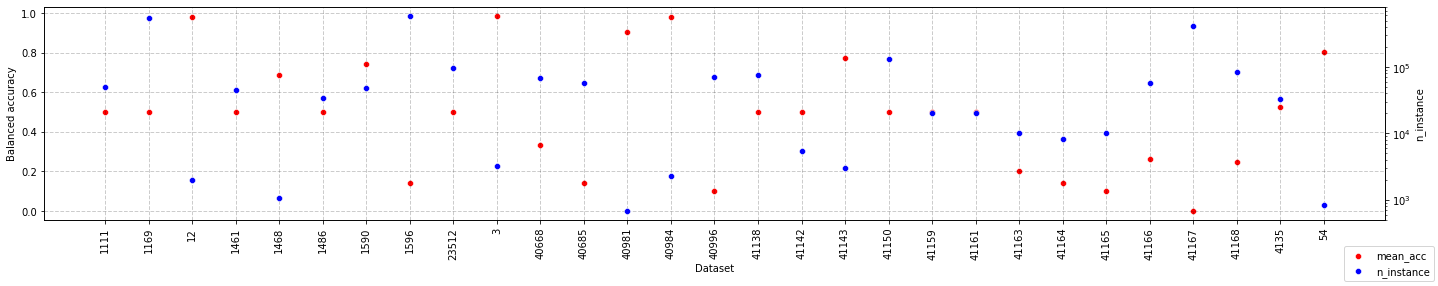

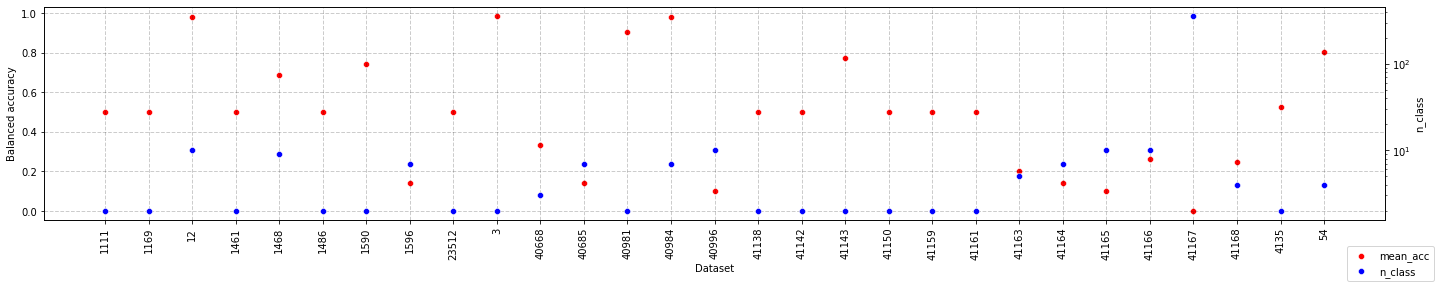

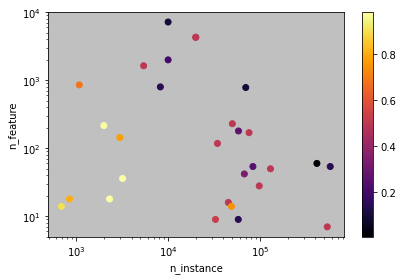

In [42]:
res_df = res_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

# Experiment 2
increased time budget = 600s, no mem limit. ensemble_nbest = 0.1

## Process results

In [ ]:
load_result = 'experiment_20211215-095915.pkl'
res = Load_result_pkl(results_folder, load_result)
res_df = Prep_res_df(res, meta_features_df)

In [ ]:
# Worst 5
res_df.sort_values('mean_acc')

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
6,41169,0.080339,0.0,65196,27,100
24,41165,0.100000,0.0,10000,7200,10
1,1596,0.142857,0.0,581012,54,7
23,41167,0.325630,0.0,416188,60,355
26,41159,0.500000,0.0,20000,4296,2
25,41161,0.500000,0.0,20000,4296,2
8,23517,0.513989,0.0,96320,21,2
18,1169,0.517897,0.0,539383,7,2
0,41168,0.565081,0.0,83733,54,4
22,1464,0.647059,0.0,748,4,2


In [ ]:
res_df.shape

(30, 6)

In [ ]:
res_df['dataset']

0     41168
1      1596
2     41150
3     40668
4         3
5     23512
6     41169
7      1067
8     23517
9        31
10    41146
11    40984
12       54
13     1461
14    40981
15     1590
16     4135
17    40685
18     1169
19    40975
20    41027
21     1489
22     1464
23    41167
24    41165
25    41161
26    41159
27    41163
28    41142
29     1468
Name: dataset, dtype: object

In [ ]:
print(res['41169']['cls'][0])
print(res['41169']['cls'][0].sprint_statistics())

AutoSklearnClassifier(ensemble_nbest=0.1, memory_limit=None,
                      metric=balanced_accuracy, per_run_time_limit=60,
                      scoring_functions=[precision, recall], seed=3003105692,
                      time_left_for_this_task=600)
auto-sklearn results:
  Dataset name: 41169
  Metric: balanced_accuracy
  Best validation score: 0.081789
  Number of target algorithm runs: 11
  Number of successful target algorithm runs: 1
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 9
  Number of target algorithms that exceeded the memory limit: 0



## Figures

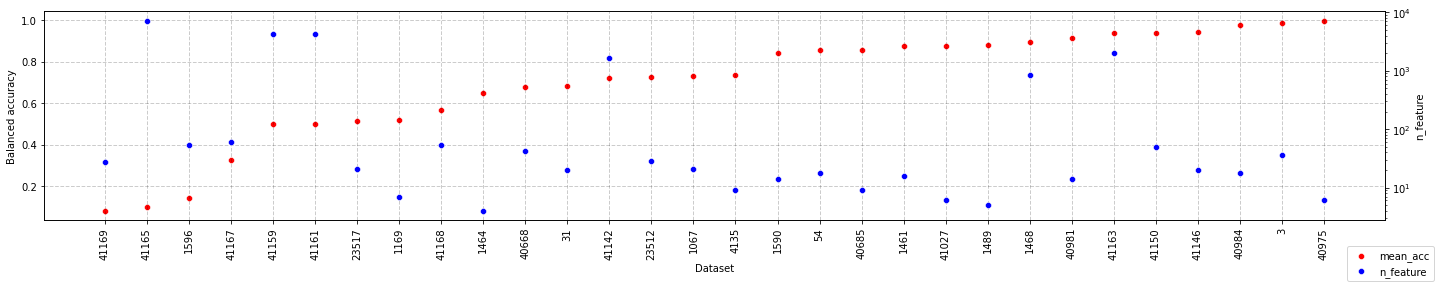

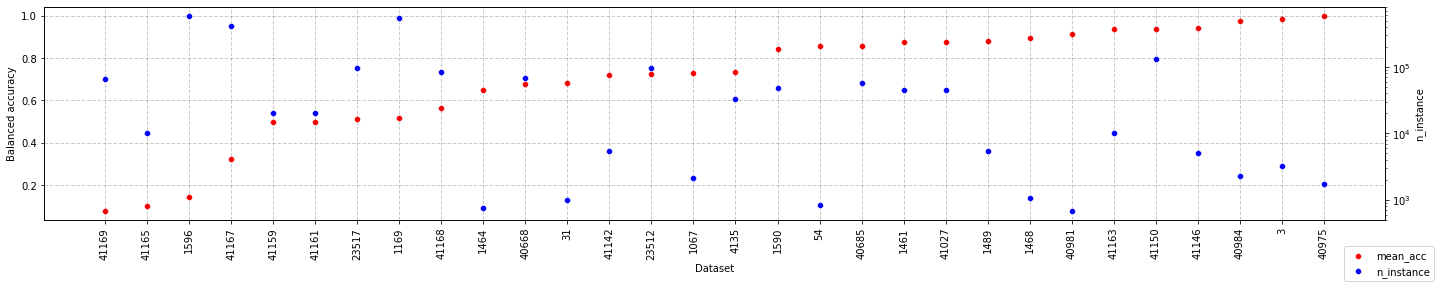

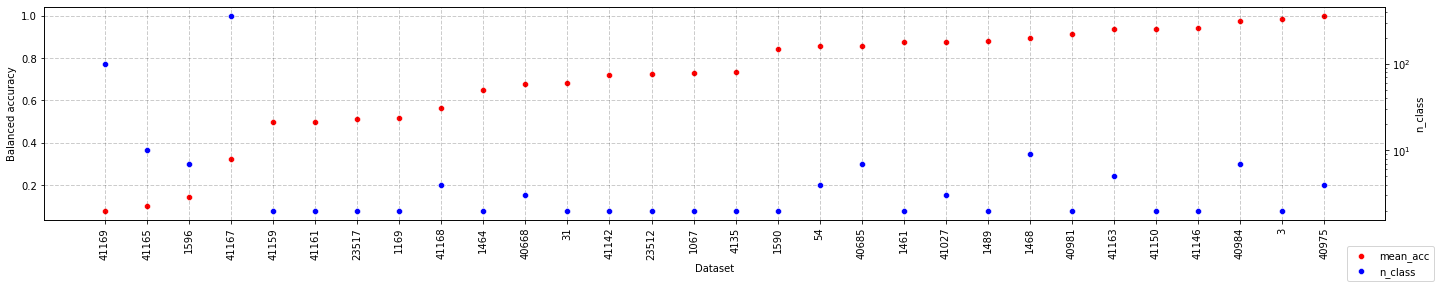

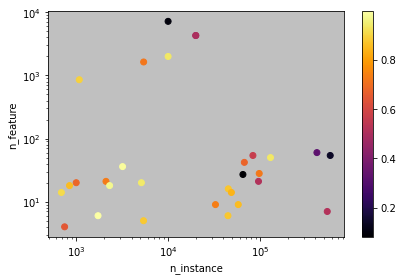

In [ ]:
res_df = res_df

y1, y2 = 'mean_acc', 'n_feature'
g1 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_instance'
g2 = Compare_acc_meta_feature(res_df, y1, y2)

y1, y2 = 'mean_acc', 'n_class'
g3 = Compare_acc_meta_feature(res_df, y1, y2)

g4 = Scatter_acc_meta_feature(res_df)

In [48]:
res_df

,dataset,mean_acc,sd_acc,n_instance,n_feature,n_class
0,1468,0.686179,3.855024e-01,1080,856,9
1,41164,0.142857,5.551115e-17,8237,800,7
2,40996,0.100000,2.775558e-17,70000,784,10
3,1111,0.500000,0.000000e+00,50000,230,2
4,12,0.977787,8.792063e-02,2000,216,10
5,41166,0.264318,3.354135e-02,58310,180,10
6,41138,0.500000,0.000000e+00,76000,170,2
7,41165,0.100000,2.775558e-17,10000,7200,10
8,41161,0.500000,0.000000e+00,20000,4296,2
9,41159,0.500000,0.000000e+00,20000,4296,2
